In [1]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import time
import rosbag
from cv_bridge import CvBridge
import cv2
import transforms3d.quaternions as quaternions
import transforms3d.euler as euler
from robot_fk import *
from camera import *
from utils import *
from particle_filter import *
bridge = CvBridge()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Get a sample data!!
bag = rosbag.Bag('taurus_dataset/vertical_circle_2021-06-16-12-16-27.bag')

robot_state_list = []
robot_state_ts   = []

img_list  = []
img_ts    = []



for topic, msg, t in bag.read_messages(topics=['/rgb/image_raw', 
                                               '/rgb/camera_info', 
                                               '/robot_pose_status']):
    if topic == '/rgb/image_raw':
        img_list.append(msg)
        img_ts.append(msg.header.stamp.to_sec())
    elif topic == '/robot_pose_status':
        robot_state_list.append(msg)
        robot_state_ts.append(msg.header.stamp.to_sec())
    elif topic == '/rgb/camera_info':
        camera_info = msg
        

bag.close()

In [3]:
P = np.array(camera_info.P).reshape(3,4)[:,:3]
D = np.array(camera_info.D)
offset = np.array([camera_info.roi.x_offset,camera_info.roi.y_offset])

img_ts  = np.array(img_ts)
robot_state_ts = np.array(robot_state_ts)

taurus = Taurus_FK("point_feature.json")
camera = Camera(P,D,offset)

def detect_point_features(idx):
    # detecting point features from given image
    # since we run point detection beforehand, we load detection instead
    keypoint_idx = [1,3,4,5,6]
    observed_point_features = np.load("vertical_circle_detection.npy")
    points = observed_point_features[idx,keypoint_idx,:2]
    confidence = observed_point_features[idx,keypoint_idx,2]
    return points, confidence

# camera-robot_tf_echo.txt
rosrun tf tf_echo k4a_color taurus_base_link
At time 0.000
- Translation: [-0.049, -0.377, 0.544]
- Rotation: in Quaternion [-0.113, 0.099, 0.691, 0.707] 
            in RPY (radian) [-0.025, 0.301, 1.545]
            in RPY (degree) [-1.406, 17.234, 88.505]

In [4]:
# initial extrinsic parameters from camera-robot_tf_echo.txt
vec, the = quaternions.quat2axangle([0.707, -0.113, 0.099, 0.691]) #function takes wxyz
rvec_init = vec*the
tvec_init = m_2_inch([-0.049, -0.377, 0.544])

rvec = rvec_init
tvec = tvec_init

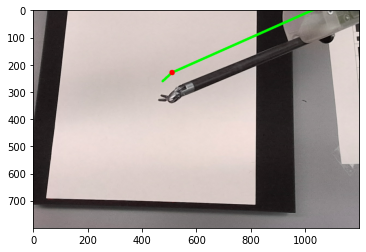

In [5]:
img_idx = 10
t = img_ts[img_idx]
robot_state_msg_idx = np.argmin(np.abs(t - robot_state_ts))
left_joint_angles = robot_state_list[robot_state_msg_idx].arm_poses[0].joint_angles

cv_img = bridge.imgmsg_to_cv2(img_list[img_idx], desired_encoding="passthrough")
img = cv_img[:,:,:3].copy()

img = camera.draw_skeleton(left_joint_angles,rvec,tvec,img, taurus)

plt.imshow(img)

# tracking with particle filter 

In [6]:
# initialize particle filter
# particle filter parameters
sigma_t = 0.01 #0.005 #inch
sigma_r = 0.003   #0.035 #2 degrees
#sigma_j = 0.001
#u_j     = 0.002
scale_init_sigma = 10
gamma = 1.0
n_particles = 200
n_eff = 0.5
resample_proportion = 0

pf = ParticleFilter(prior_fn=lambda n : prior_fn(n, scale_init_sigma, sigma_t, sigma_r), 
                    observe_fn=project_feature_points,
                    n_particles=n_particles,
                    dynamics_fn=identity,
                    noise_fn=lambda x, **kwargs: 
                                gaussian_noise(x, sigmas=[sigma_t, sigma_t, sigma_t, 
                                                          sigma_r, sigma_r, sigma_r]),
                    weight_fn=weight_function,
                    resample_proportion=resample_proportion,
                    resample_fn = stratified_resample,
                    n_eff_threshold = n_eff)
pf.init_filter()   


In [7]:
video = cv2.VideoWriter("video.mp4",  cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 20, (img.shape[1],img.shape[0]))


for idx in range(len(img_list)):
    
    # receive images
    cv_img = bridge.imgmsg_to_cv2(img_list[idx], desired_encoding="passthrough")
    img = cv_img[:,:,:3].copy()
    
    # receive joint angles
    t = img_ts[idx]
    robot_state_msg_idx = np.argmin(np.abs(t - robot_state_ts))
    left_joint_angles = robot_state_list[robot_state_msg_idx].arm_poses[0].joint_angles
    
    # detect point features
    detected_points, confidence = detect_point_features(idx)
    
    # estimate with particle filter
    pf.update(detected_points, init_rvec=rvec_init, init_tvec=tvec_init,\
              joint_angles=left_joint_angles, confidence=confidence,\
              gamma=gamma, robot=taurus, camera=camera)
    
    # most recent prediction of the robot pose
    rvec_new, tvec_new = cv2.composeRT(rvec_init, tvec_init, pf.mean_state[3:], pf.mean_state[:3], 
                           camera.P, camera.D)[:2]
    
    # draw estimation
    img = camera.draw_skeleton(left_joint_angles,rvec_new,tvec_new,img, taurus)
    # draw initialization
    img = camera.draw_skeleton(left_joint_angles,rvec_init, tvec_init,img, taurus, color=(0,0,255))
    video.write(img)
    
video.release()

4.332344049718672e-24
2.737449052267399e-15
1.0536267134213833e-07
0.006687302112572416
0.036578416117453674
0.056620437234299645
0.05004109384112575
0.045870538023113215
0.023051185927496692
0.059622061549071334
0.04478428271709197
0.02948511971158312
0.029750232202966
0.02921528304925988
0.04088800203041757
0.0515538406107323
0.03825643215509551
0.004640096441128651
0.0036412725242296177
0.0005342161077297263
0.0032238215371025417
0.00048621597948165894
1.9608359719252964e-14
4.1406412866889515e-17
8.805118004275392e-19
0.0003497964501861561
0.003459768121014959
3.0150663134029226e-05
0.012641867993886426
0.022469858393241074
0.02457319159368597
0.04027492549764494
0.028947640736273567
0.01660570522963359
0.033704958418395166
0.04237830323004642
0.03419448518641874
0.01652165524239505
0.031105245857092623
0.03272267575672127
0.024937539859969063
0.03470559909031548
0.022690566906798174
0.01825538750291732
0.04564169159658164
0.03152377843494328
0.026895990154146322
0.0181063684217960